<a href="https://colab.research.google.com/github/EvidenceN/DS-Unit-2-Kaggle-Challenge/blob/master/module4/Evidence.N%20Final_Answers_Assignment_kaggle_challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Metrics


Assignment

If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.

 Plot a confusion matrix for your Tanzania Waterpumps model.
 
Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).

 Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
Commit your notebook to your fork of the GitHub repo.

[ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.

In [1]:
# Plot confusion matrix for tanzania waterpump model. 

# get the data from yesterday and the best model parameters from yersterday and use it build a confusion matrix

!pip install category_encoders==2.*

import pandas as pd

# Defining features and labels
train_features = 'https://raw.githubusercontent.com/EvidenceN/DS-Unit-2-Kaggle-Challenge/master/data/waterpumps/train_features.csv'

train_labels = 'https://raw.githubusercontent.com/EvidenceN/DS-Unit-2-Kaggle-Challenge/master/data/waterpumps/train_labels.csv'

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(train_features), 
                 pd.read_csv(train_labels))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv("https://raw.githubusercontent.com/EvidenceN/DS-Unit-2-Kaggle-Challenge/master/data/waterpumps/test_features.csv")

     |████████████████████████████████| 102kB 2.5MB/s 


In [0]:

from sklearn.model_selection import train_test_split

train, val = train_test_split(train, test_size = len(test), stratify=train['status_group'], random_state = 42)

In [0]:

val.shape

# %%
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [4]:
# creating a function to clean all data the same way. 
import numpy as np

def cleaning(x):
  """Clean train, validate, and test data sets in the same way
  
    DataFrame.copy(self, deep=True)[source]

    Make a copy of this object’s indices and data.

    When deep=True (default), a new object will be created with a copy of the 
    calling object’s data and indices. Modifications to the data or indices of 
    the copy will not be reflected in the original object (see notes below).

    When deep=False, a new object will be created without copying the calling 
    object’s data or index (only references to the data and index are copied). 
    Any changes to the data of the original will be reflected in the shallow 
    copy (and vice versa)."""

  x = x.copy()

  cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']

  for col in cols_with_zeros:
      x[col] = x[col].replace(0, np.nan)
      x[col+'_MISSING'] = x[col].isnull()

  duplicates = ['quantity_group', 'payment_type']
  x = x.drop(columns=duplicates)

  unusable_variance = ['recorded_by', 'id']
  x = x.drop(columns=unusable_variance)
    
  # Convert date_recorded to datetime
  x['date_recorded'] = pd.to_datetime(x['date_recorded'], infer_datetime_format=True)
    
  # Extract components from date_recorded, then drop the original column
  x['year_recorded'] = x['date_recorded'].dt.year
  x['month_recorded'] = x['date_recorded'].dt.month
  x['day_recorded'] = x['date_recorded'].dt.day
  x = x.drop(columns='date_recorded')
    
  # Engineer feature: how many years from construction_year to date_recorded
  x['years'] = x['year_recorded'] - x['construction_year']
  x['years_MISSING'] = x['years'].isnull()
    
  # return the wrangled dataframe
  return x

#
train = cleaning(train)
test = cleaning(test)
val = cleaning(val)
#
# defining mean baseline. 
mean_baseline = train['status_group'].value_counts(normalize=True)

print(f'mean baseline\n{mean_baseline}')

# defining the target and features
target = 'status_group'
features = train.columns.drop(target)

x_train = train[features]
y_train = train[target]
x_val = val[features]
y_val = val[target]
x_test = test[features]

mean baseline
functional                 0.543071
non functional             0.384241
functional needs repair    0.072688
Name: status_group, dtype: float64


In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=42, max_features=0.26893254140057554, max_depth=50,
	n_estimators=394, min_samples_split=7, n_jobs = -2)
)



In [8]:
import seaborn as sns
from sklearn.metrics import accuracy_score

# fit on train data and validate on validation data

pipeline.fit(x_train, y_train)
y_pred_val = pipeline.predict(x_val)
print(f'Validation accuracy {accuracy_score(y_val, y_pred_val)}')


Validation accuracy 0.8139016576124809


                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      7798
functional needs repair       0.64      0.29      0.40      1043
         non functional       0.85      0.78      0.81      5517

               accuracy                           0.81     14358
              macro avg       0.76      0.66      0.69     14358
           weighted avg       0.81      0.81      0.80     14358



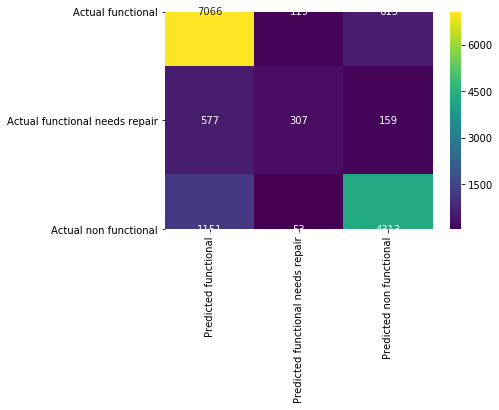

In [9]:

# plotting the confusion matrix of the data

from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, y_pred_val)

#%%
# getting the labels from the confusion matrix

from sklearn.utils.multiclass import unique_labels

unique_labels(y_val)

#%%

# Create a function that will graph the confusion matrix and put labels next to it. 

def plot_confusion_matrix(y_true, y_pred):
	labels = unique_labels(y_true)
	columns = [f'Predicted {label}' for label in labels]
	index = [f'Actual {label}' for label in labels]
	table = pd.DataFrame(confusion_matrix(y_true, y_pred), columns=columns,
	index=index)
	return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

#%%%
plot_confusion_matrix(y_val, y_pred_val)

#%%

from sklearn.metrics import classification_report

report = classification_report(y_val, y_pred_val)

print(report)
